Epoch 0, Loss: 0.531603
Epoch 500, Loss: 0.000247
Epoch 1000, Loss: 0.000065
Epoch 1500, Loss: 0.000016
Epoch 2000, Loss: 0.000003
Epoch 2500, Loss: 0.000001
Epoch 3000, Loss: 0.000001
Epoch 3500, Loss: 0.000001
Epoch 4000, Loss: 0.000001
Epoch 4500, Loss: 0.000001


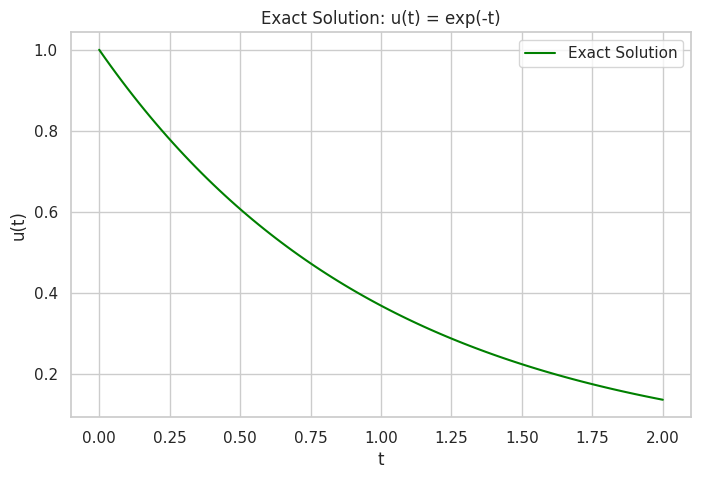

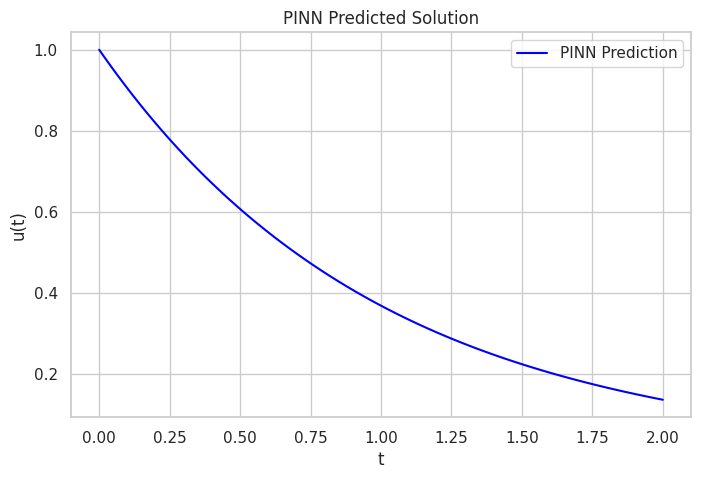

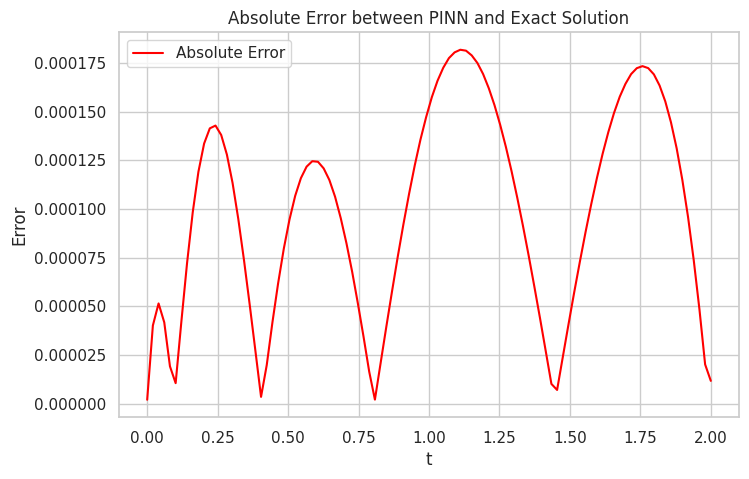

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

# Plot style
sns.set(style='whitegrid')

# Define the PINN model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, t):
        return self.net(t)

# Physics-informed loss
def pinn_loss(model, t):
    t.requires_grad = True
    u = model(t)
    du_dt = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    residual = du_dt + u
    return torch.mean(residual**2)

# Initial condition loss
def initial_condition_loss(model):
    u0_pred = model(torch.tensor([[0.0]]))
    return (u0_pred - 1.0)**2

# Training setup
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
t_train = torch.linspace(0, 2, 100).view(-1, 1)

# Train the model
for epoch in range(5000):
    optimizer.zero_grad()
    loss = pinn_loss(model, t_train) + initial_condition_loss(model)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# Predictions
t_test = torch.linspace(0, 2, 100).view(-1, 1)
u_pred = model(t_test).detach().numpy().flatten()
u_exact = np.exp(-t_test.numpy().flatten())
error = np.abs(u_pred - u_exact)

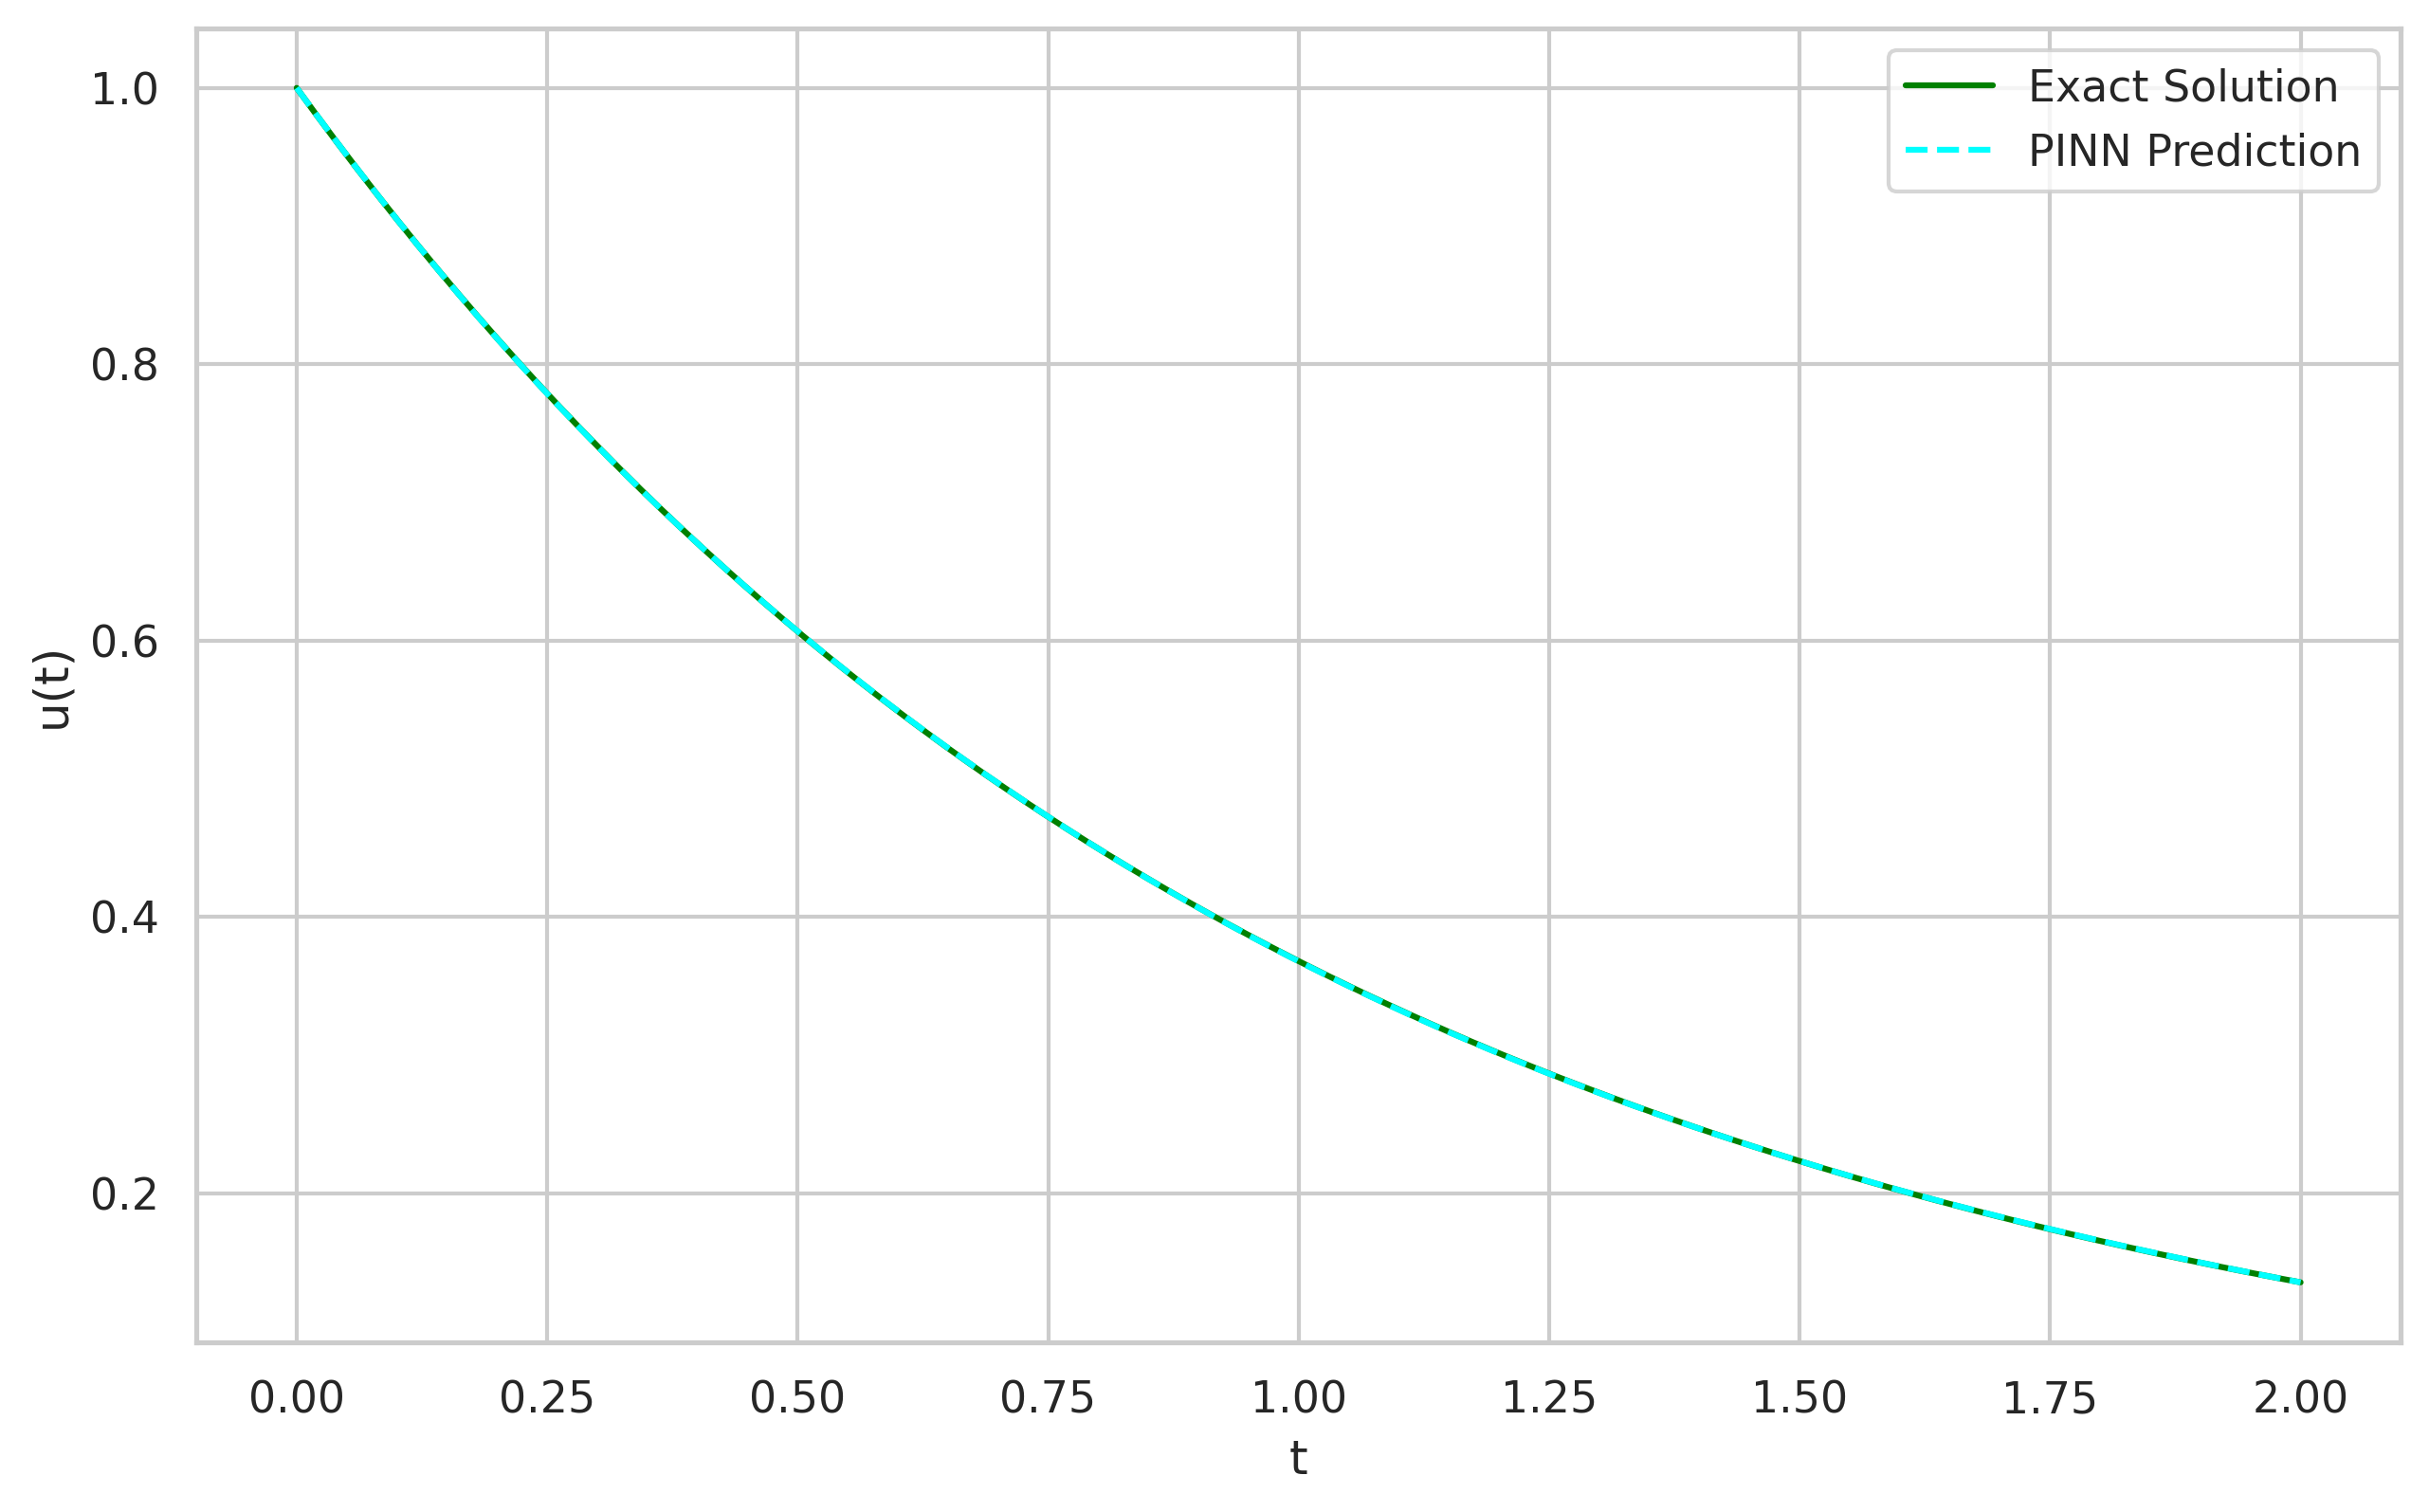

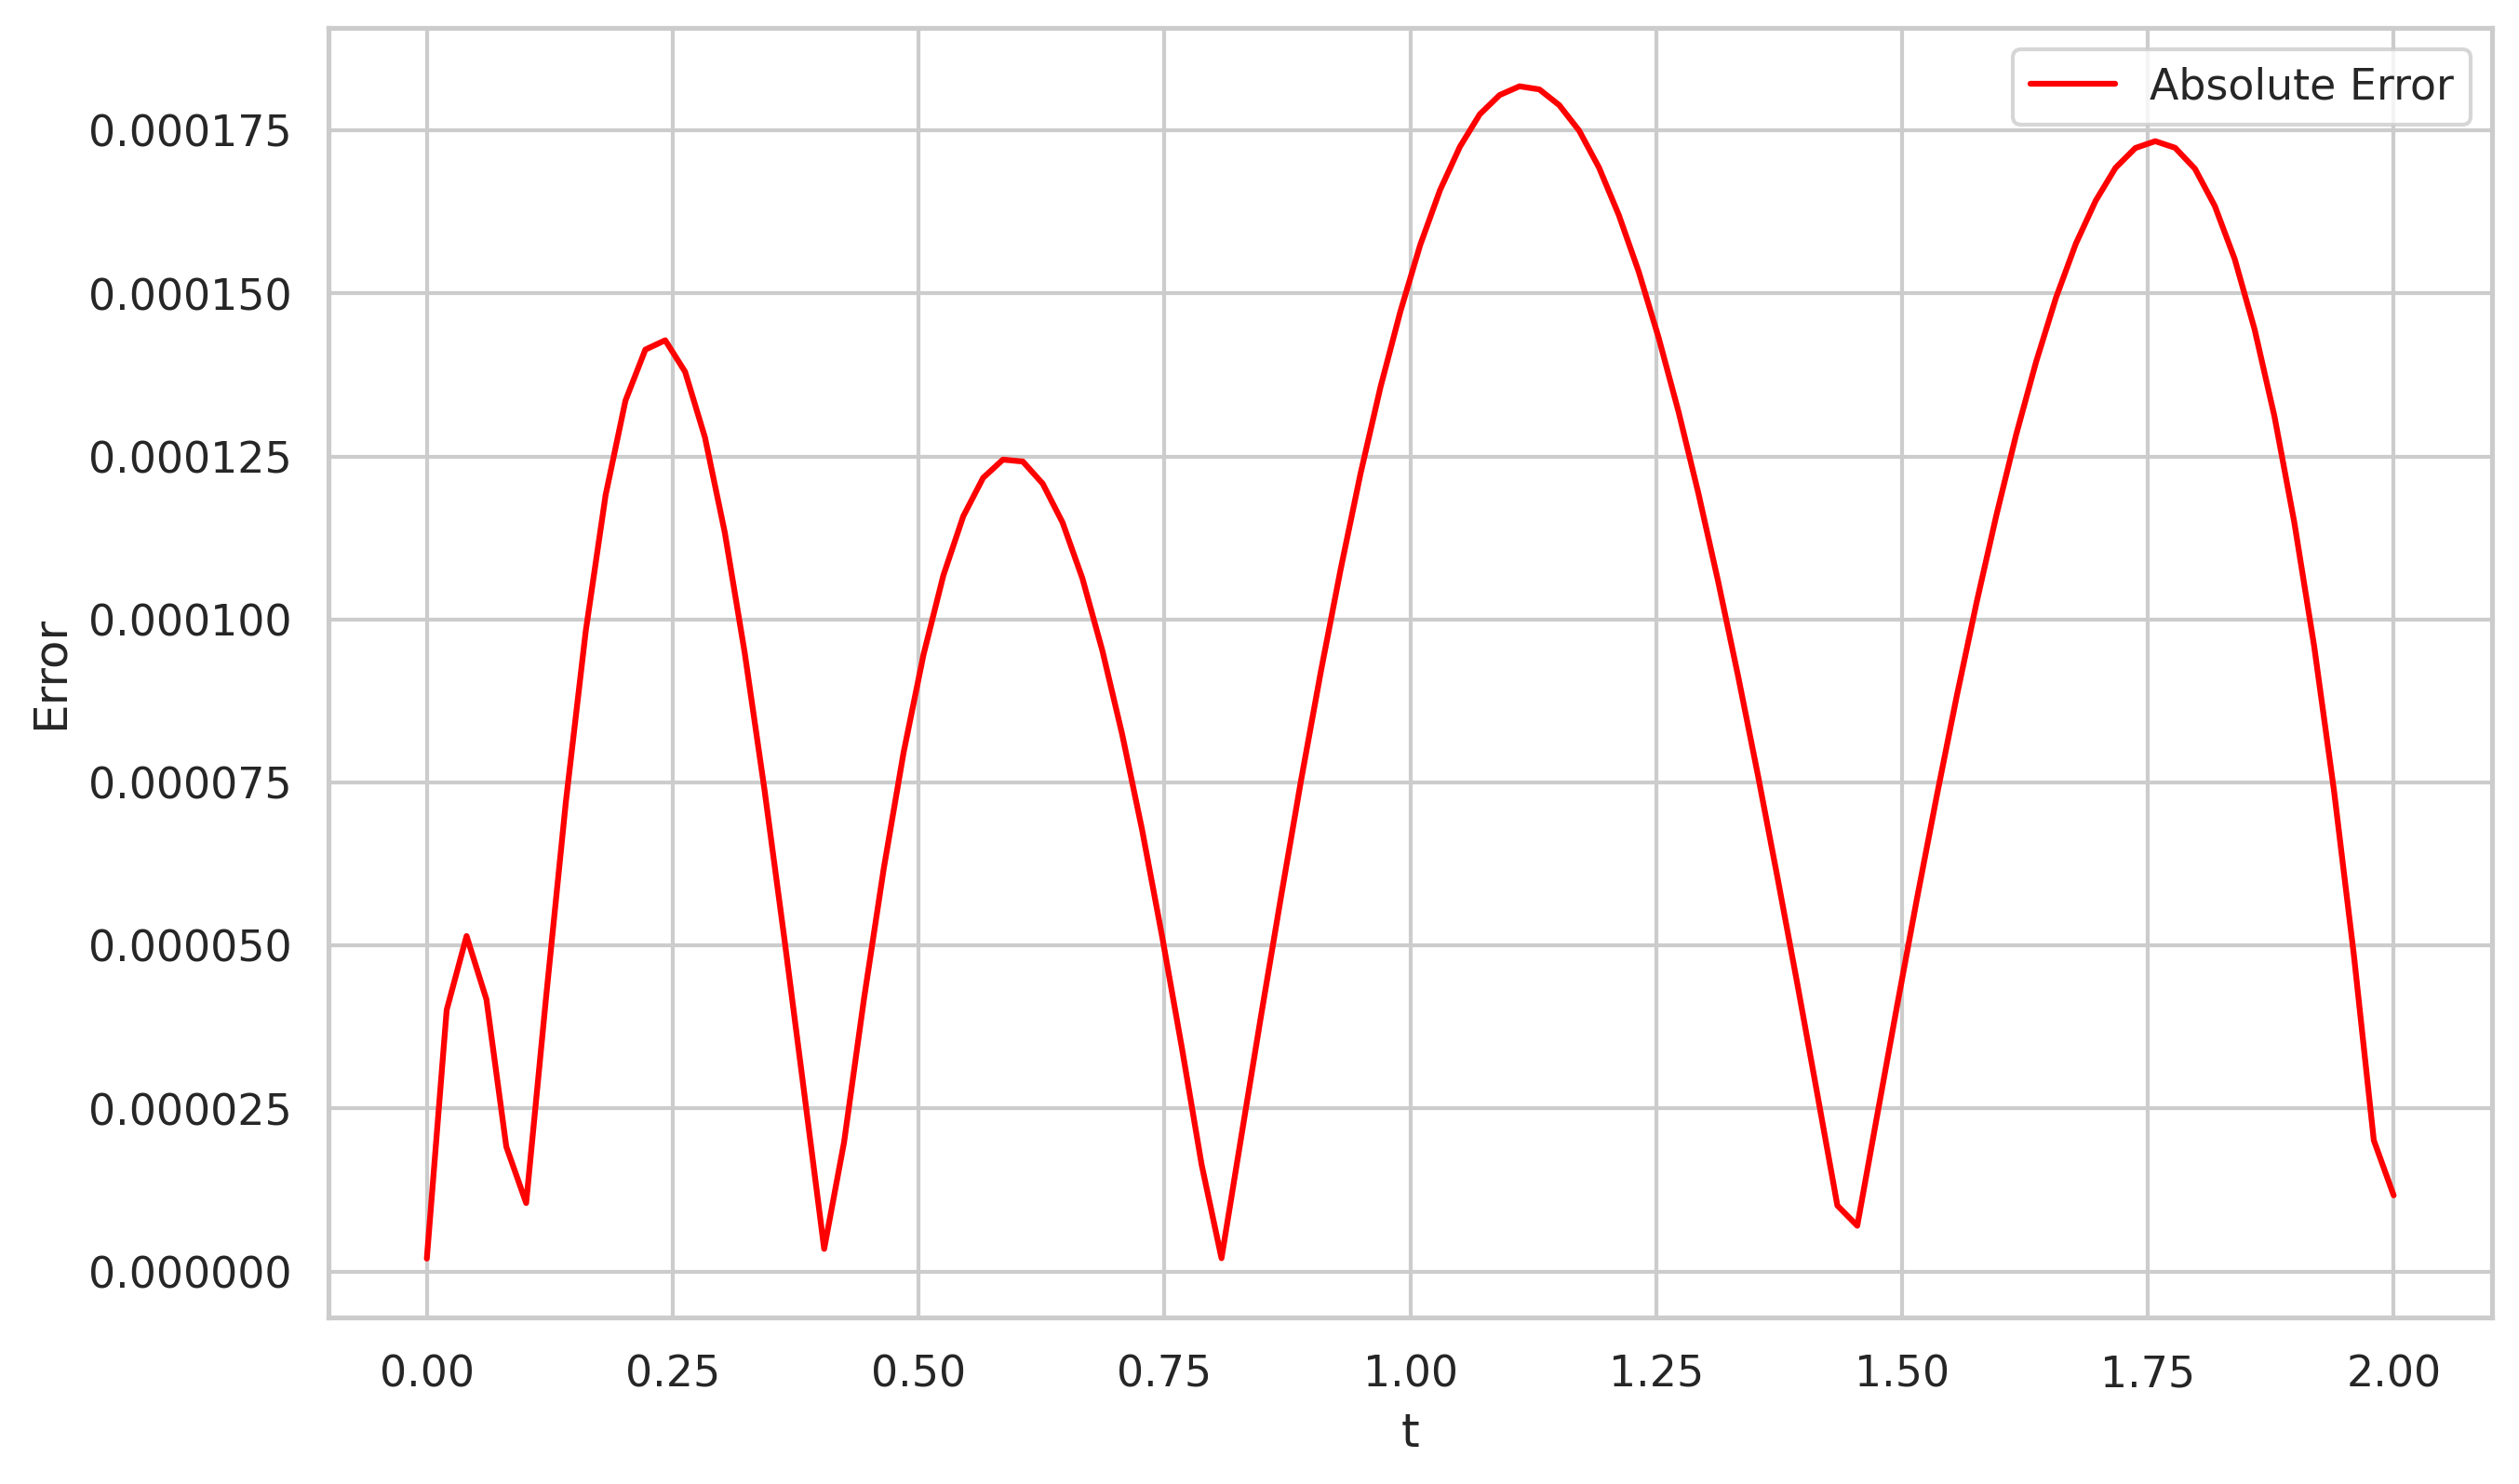

In [ ]:
# Plot: prediction PINN vs Exact solution
plt.figure(figsize=(10, 6), dpi =300)
plt.plot(t_test.numpy(), u_exact, label='Exact Solution', color='green')
plt.plot(t_test.numpy(), u_pred, label='PINN Prediction', color='cyan', linestyle='dashed')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title('PINN Predicted Solution')
plt.legend()
plt.show()

# Plot: Absolute error
plt.figure(figsize=(10, 6), dpi = 300)
plt.plot(t_test.numpy(), error, label='Absolute Error', color='red')
plt.xlabel('t')
plt.ylabel('Error')
plt.title('Absolute Error between PINN and Exact Solution')
plt.legend()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --------------------------------------------------
# 1. Define the Neural Network Architecture (PINN)
# --------------------------------------------------
class PINN(nn.Module):
    """A simple fully-connected neural network."""
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.activation = nn.Tanh()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        # Concatenate x and t to form the input tensor [x, t]
        inputs = torch.cat([x, t], dim=1)
        for i, layer in enumerate(self.layers):
            inputs = layer(inputs)
            # Apply activation function to all but the last layer
            if i < len(self.layers) - 1:
                inputs = self.activation(inputs)
        return inputs

# --------------------------------------------------
# 2. Define Problem Parameters and Analytical Solution
# --------------------------------------------------
# For simplicity, let alpha = 1/pi^2, so the analytical solution is simpler
alpha = 1.0 / (np.pi**2)
x_domain = [0.0, 1.0]
t_domain = [0.0, 1.0]

def analytical_solution(x, t, alpha_val):
    """Analytical solution for the given heat equation problem."""
    return np.exp(-np.pi**2 * alpha_val * t) * np.sin(np.pi * x)

# --------------------------------------------------
# 3. Define the Physics-Informed Loss Function
# --------------------------------------------------
def pde_residual_loss(model, x_f, t_f):
    """Computes the PDE residual: u_t - alpha * u_xx."""
    # Enable gradient tracking for inputs
    x_f.requires_grad = True
    t_f.requires_grad = True

    # Get model prediction
    u = model(x_f, t_f)

    # Compute derivatives using torch.autograd.grad
    u_t = torch.autograd.grad(u, t_f, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_f, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_f, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    # Calculate the PDE residual
    residual = u_t - alpha * u_xx
    return torch.mean(residual**2)

# --------------------------------------------------
# 4. Generate Training Data
# --------------------------------------------------
# Number of data points
N_ic = 200   # Initial condition
N_bc = 200   # Boundary condition
N_f = 5000  # PDE collocation points

# Initial Condition (IC) points at t=0
x_ic = torch.rand((N_ic, 1), device=device) * (x_domain[1] - x_domain[0])
t_ic = torch.zeros((N_ic, 1), device=device)
u_ic = torch.sin(np.pi * x_ic) # u(x,0) = sin(pi*x)

# Boundary Condition (BC) points at x=0 and x=1
t_bc = torch.rand((N_bc, 1), device=device) * (t_domain[1] - t_domain[0])
x_bc_0 = torch.zeros((N_bc // 2, 1), device=device) # x=0
x_bc_1 = torch.ones((N_bc // 2, 1), device=device)  # x=1
x_bc = torch.cat([x_bc_0, x_bc_1], dim=0)
t_bc = torch.cat([t_bc[:N_bc//2], t_bc[N_bc//2:]], dim=0)
u_bc = torch.zeros((N_bc, 1), device=device) # u(0,t)=0, u(1,t)=0

# Collocation points (for PDE residual) inside the domain
x_f = torch.rand((N_f, 1), device=device) * (x_domain[1] - x_domain[0])
t_f = torch.rand((N_f, 1), device=device) * (t_domain[1] - t_domain[0])

# --------------------------------------------------
# 5. Training the PINN
# --------------------------------------------------
# Network architecture: [inputs, hidden_layers..., output]
layers = [2, 32, 32, 32, 32, 1]
pinn_model = PINN(layers).to(device)
optimizer = torch.optim.Adam(pinn_model.parameters(), lr=1e-3)
epochs = 5000

print("Starting training...")
for epoch in range(epochs + 1):
    pinn_model.train()

    # --- Calculate losses ---
    # Initial Condition Loss
    u_pred_ic = pinn_model(x_ic, t_ic)
    loss_ic = torch.mean((u_pred_ic - u_ic)**2)

    # Boundary Condition Loss
    u_pred_bc = pinn_model(x_bc, t_bc)
    loss_bc = torch.mean((u_pred_bc - u_bc)**2)

    # PDE Residual Loss
    loss_f = pde_residual_loss(pinn_model, x_f, t_f)

    # Total Loss (simple sum, weights can be added)
    loss = loss_ic + loss_bc + loss_f

    # --- Backpropagation ---
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f'Epoch {epoch}/{epochs} -> Total Loss: {loss.item():.4e} '
              f'(IC: {loss_ic.item():.4e}, BC: {loss_bc.item():.4e}, PDE: {loss_f.item():.4e})')

print("Training finished.")



Using device: cpu
Starting training...
Epoch 0/5000 -> Total Loss: 8.0578e-01 (IC: 7.6639e-01, BC: 3.8400e-02, PDE: 9.8536e-04)
Epoch 200/5000 -> Total Loss: 2.0383e-02 (IC: 8.4951e-03, BC: 6.8396e-03, PDE: 5.0487e-03)
Epoch 400/5000 -> Total Loss: 4.3433e-04 (IC: 4.2556e-05, BC: 6.1226e-05, PDE: 3.3055e-04)
Epoch 600/5000 -> Total Loss: 1.3227e-04 (IC: 5.1612e-06, BC: 1.1604e-05, PDE: 1.1551e-04)
Epoch 800/5000 -> Total Loss: 8.1982e-05 (IC: 3.5195e-06, BC: 8.3816e-06, PDE: 7.0081e-05)
Epoch 1000/5000 -> Total Loss: 4.0582e-04 (IC: 1.6280e-04, BC: 1.7840e-04, PDE: 6.4623e-05)
Epoch 1200/5000 -> Total Loss: 5.2556e-05 (IC: 1.7051e-06, BC: 5.0110e-06, PDE: 4.5840e-05)
Epoch 1400/5000 -> Total Loss: 4.7601e-05 (IC: 1.5663e-06, BC: 4.7233e-06, PDE: 4.1311e-05)
Epoch 1600/5000 -> Total Loss: 5.0178e-05 (IC: 4.3080e-06, BC: 7.6994e-06, PDE: 3.8170e-05)
Epoch 1800/5000 -> Total Loss: 4.0084e-05 (IC: 1.3897e-06, BC: 4.4882e-06, PDE: 3.4207e-05)
Epoch 2000/5000 -> Total Loss: 3.7663e-05 (IC: 1


L2 Relative Error: 1.7607e-03


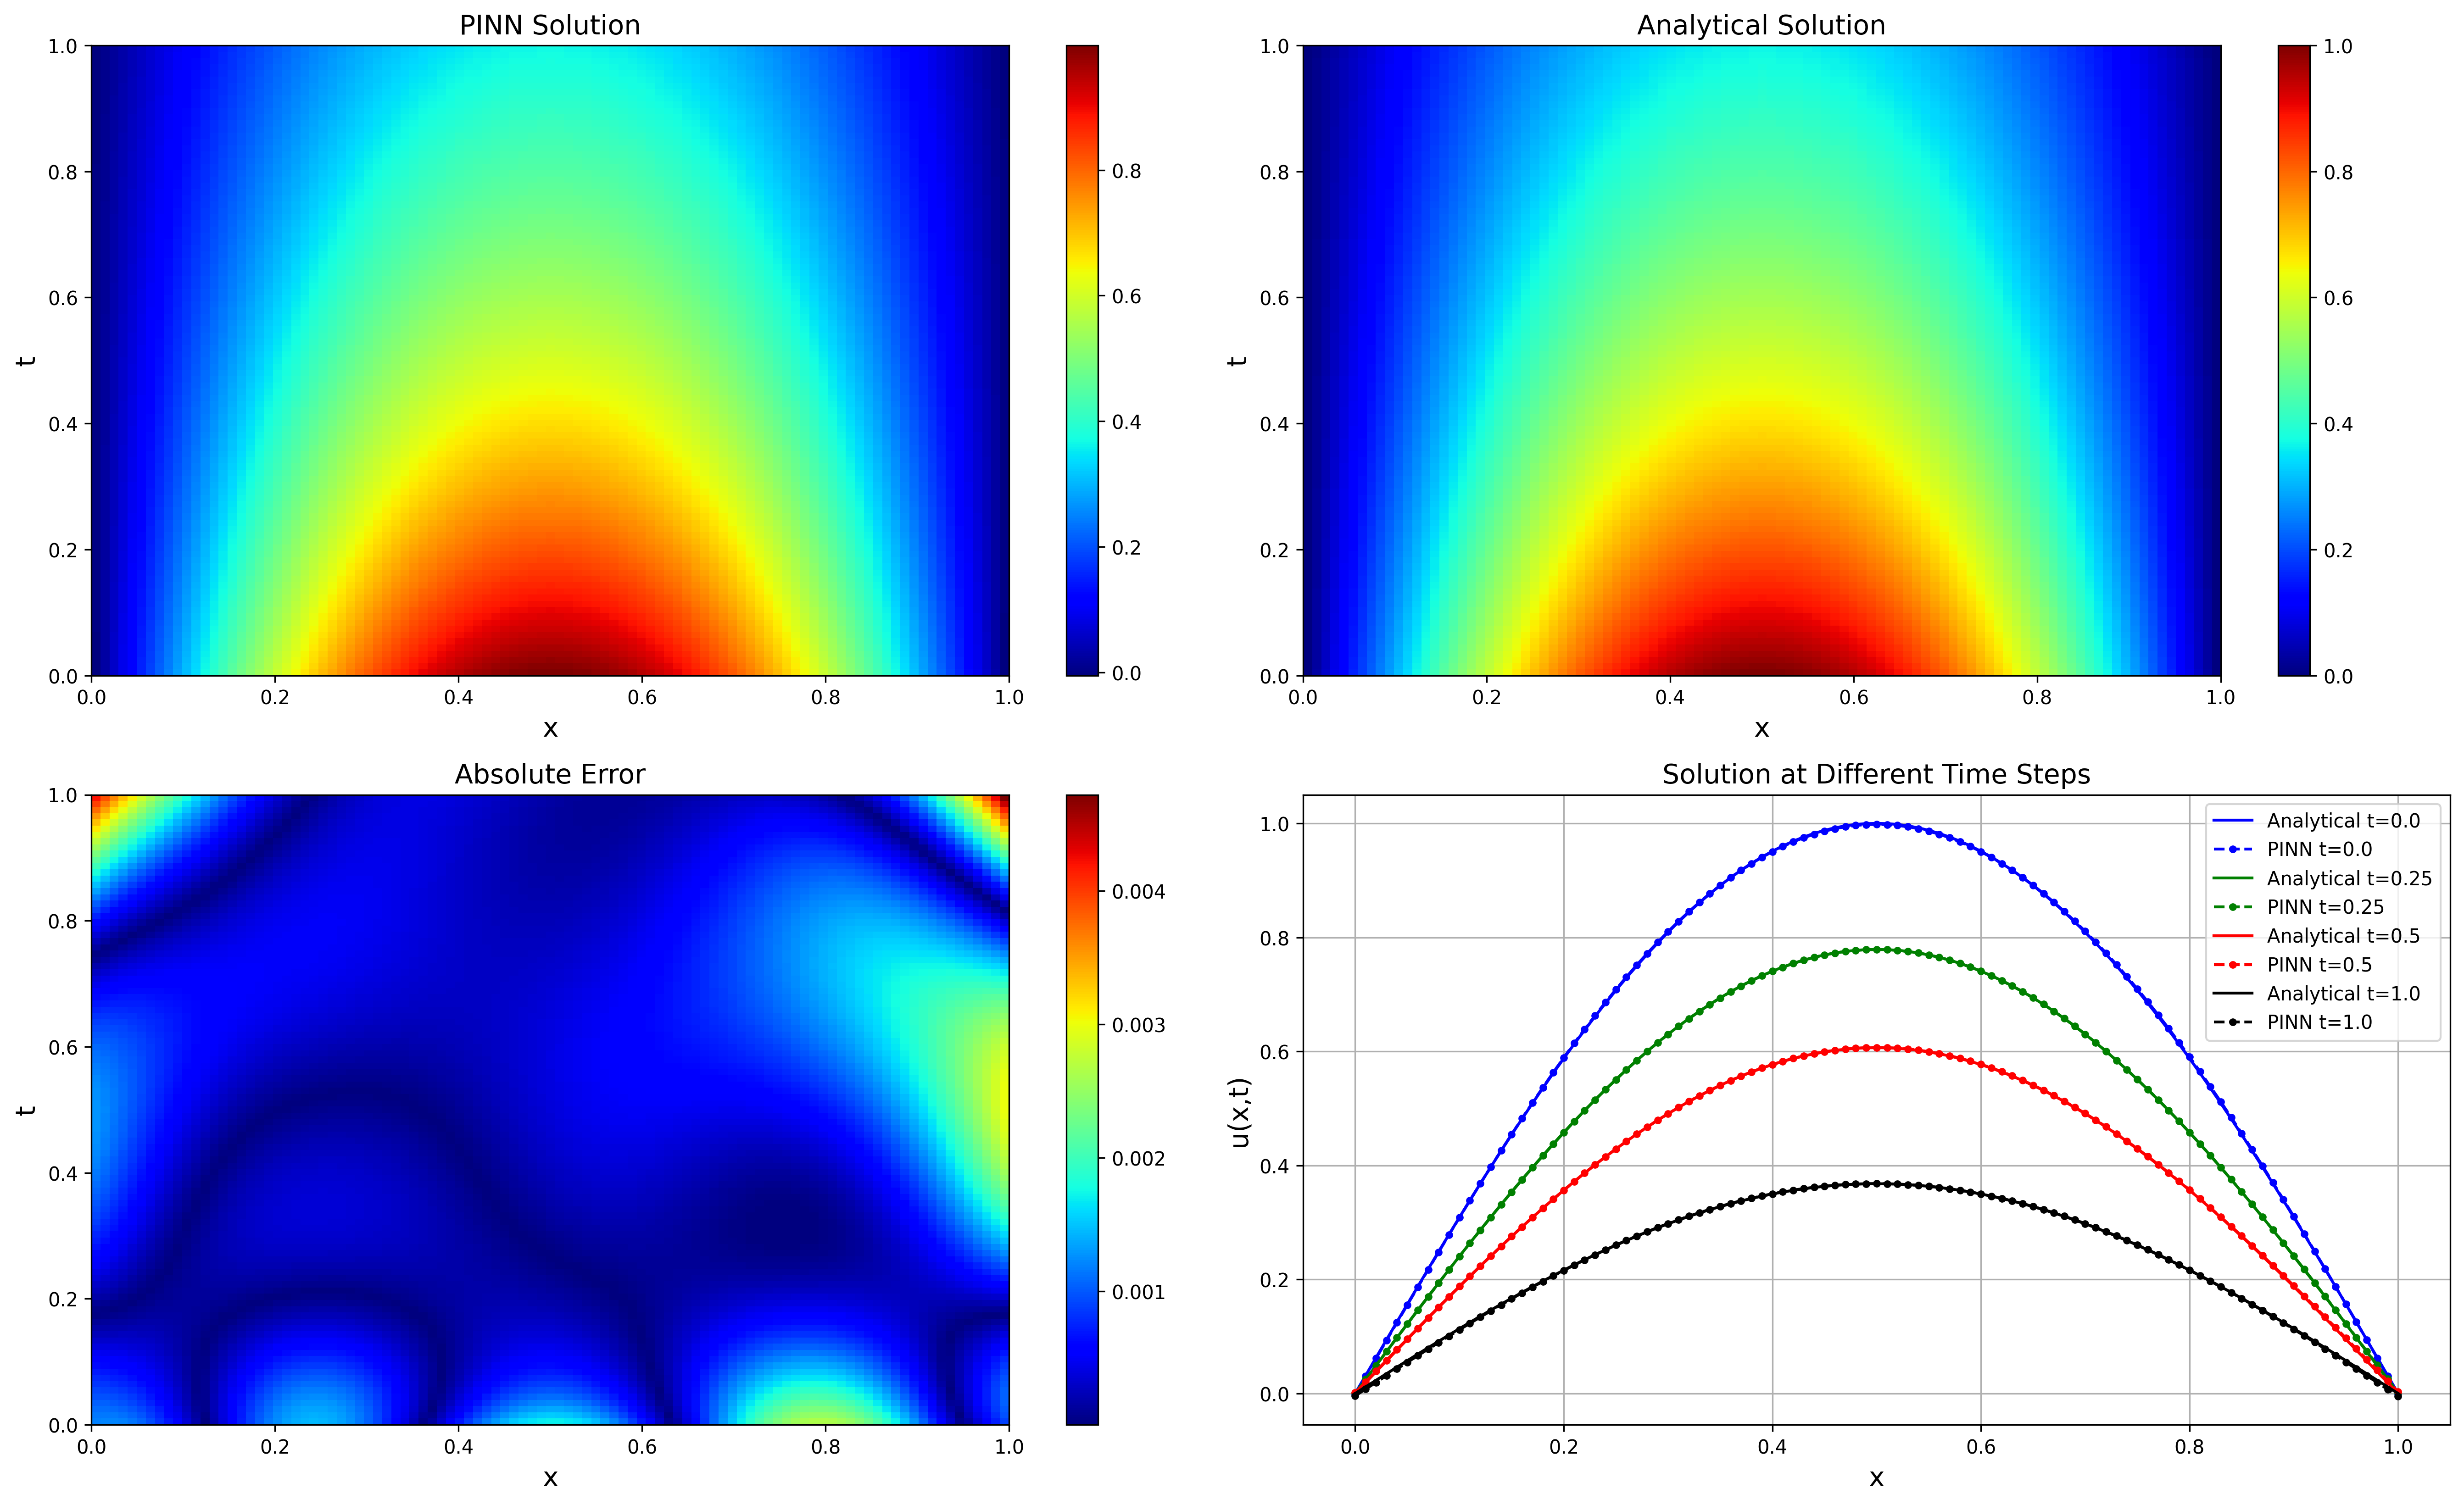

In [ ]:
# --------------------------------------------------
# 6. Evaluation and Visualization
# --------------------------------------------------
pinn_model.eval()

# Create a grid for plotting the solution
x = np.linspace(x_domain[0], x_domain[1], 101)
t = np.linspace(t_domain[0], t_domain[1], 101)
X, T = np.meshgrid(x, t)

# Flatten grid for model prediction
x_flat = X.flatten()
t_flat = T.flatten()
x_torch = torch.tensor(x_flat, dtype=torch.float32).view(-1, 1).to(device)
t_torch = torch.tensor(t_flat, dtype=torch.float32).view(-1, 1).to(device)

# Get PINN prediction on the grid
with torch.no_grad():
    u_pred = pinn_model(x_torch, t_torch).cpu().numpy()
U_pred = u_pred.reshape(X.shape)

# Get analytical solution on the grid
U_analytical = analytical_solution(X, T, alpha)

# Calculate L2 relative error
error = np.linalg.norm(U_pred - U_analytical) / np.linalg.norm(U_analytical)
print(f'\nL2 Relative Error: {error:.4e}')

# --- Plotting ---
fig = plt.figure(figsize=(18, 12), dpi = 300)
gs = GridSpec(2, 2)
#plt.suptitle("1D Heat Equation: PINN vs Analytical Solution", fontsize=16)

# Plot PINN Solution
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(U_pred, extent=[x_domain[0], x_domain[1], t_domain[0], t_domain[1]],
                 origin='lower', aspect='auto', cmap='jet')
fig.colorbar(im1, ax=ax1)
ax1.set_xlabel('x', fontsize=14)
ax1.set_ylabel('t', fontsize=14)
ax1.set_title('PINN Solution', fontsize=14)

# Plot Analytical Solution
ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(U_analytical, extent=[x_domain[0], x_domain[1], t_domain[0], t_domain[1]],
                 origin='lower', aspect='auto', cmap='jet')
fig.colorbar(im2, ax=ax2)
ax2.set_xlabel('x', fontsize=14)
ax2.set_ylabel('t', fontsize=14)
ax2.set_title('Analytical Solution', fontsize=14)

# Plot Absolute Error
ax3 = fig.add_subplot(gs[1, 0])
error_map = np.abs(U_pred - U_analytical)
im3 = ax3.imshow(error_map, extent=[x_domain[0], x_domain[1], t_domain[0], t_domain[1]],
                 origin='lower', aspect='auto', cmap='jet')
fig.colorbar(im3, ax=ax3)
ax3.set_xlabel('x', fontsize=14)
ax3.set_ylabel('t', fontsize=14)
ax3.set_title(f'Absolute Error', fontsize=14)

ax4 = fig.add_subplot(gs[1, 1])
times_to_plot = [0.0, 0.25, 0.5, 1.0]
colors = ['blue', 'green', 'red', 'black']

for t_val, color in zip(times_to_plot, colors):
    # Analytical solution at t_val
    u_analytical_t = analytical_solution(x, np.full_like(x, t_val), alpha)
    ax4.plot(x, u_analytical_t, color=color, linestyle='-', label=f'Analytical t={t_val}')

    # PINN solution at t_val
    x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1).to(device)
    t_tensor = torch.full_like(x_tensor, t_val)
    with torch.no_grad():
        u_pinn_t = pinn_model(x_tensor, t_tensor).cpu().numpy()
    ax4.plot(x, u_pinn_t, color=color, linestyle='--', marker='o', markersize=3, label=f'PINN t={t_val}')
ax4.set_xlabel('x', fontsize=14)
ax4.set_ylabel('u(x,t)', fontsize=14)
ax4.set_title(f'Solution at Different Time Steps', fontsize=14)
ax4.legend()
ax4.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --------------------------------------------------
# 1. Define the Neural Network Architecture (PINN)
# --------------------------------------------------
class PINN(nn.Module):
    """A simple fully-connected neural network."""
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.activation = nn.Tanh()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        for i, layer in enumerate(self.layers):
            inputs = layer(inputs)
            if i < len(self.layers) - 1:
                inputs = self.activation(inputs)
        return inputs

# --------------------------------------------------
# 2. Define Problem Parameters & Exact Solution
# --------------------------------------------------
nu = 0.1
x_domain = [-3.0, 3.0]
t_domain = [0.0, 1.0]

def exact_solution(x, t, nu_val):
    """Exact solution for the given Burgers' equation problem."""
    return 1.0 - torch.tanh((x - t) / (2.0 * nu_val))

# --------------------------------------------------
# 3. Define the Physics-Informed Loss Function
# --------------------------------------------------
def pde_residual_loss(model, x_f, t_f, nu_val):
    """Computes the Burgers' PDE residual: u_t + u*u_x - nu*u_xx."""
    x_f.requires_grad = True
    t_f.requires_grad = True
    u = model(x_f, t_f)

    # Compute derivatives using torch.autograd.grad
    u_t = torch.autograd.grad(u, t_f, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_f, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_f, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    # Calculate the PDE residual
    residual = u_t + u * u_x - nu_val * u_xx
    return torch.mean(residual**2)

# --------------------------------------------------
# 4. Generate Training Data
# --------------------------------------------------
N_ic = 200   # Initial condition
N_bc = 200   # Boundary condition
N_f = 5000  # PDE collocation points

# Initial Condition (IC) points at t=0
x_ic = (torch.rand((N_ic, 1), device=device) * (x_domain[1] - x_domain[0]) + x_domain[0])
t_ic = torch.zeros((N_ic, 1), device=device)
u_ic = exact_solution(x_ic, t_ic, nu)

# Boundary Condition (BC) points at x=-3 and x=3
t_bc = torch.rand((N_bc, 1), device=device) * (t_domain[1] - t_domain[0])
x_bc_left = torch.full((N_bc // 2, 1), x_domain[0], device=device)
x_bc_right = torch.full((N_bc // 2, 1), x_domain[1], device=device)
x_bc = torch.cat([x_bc_left, x_bc_right], dim=0)
t_bc = torch.cat([t_bc[:N_bc//2], t_bc[N_bc//2:]], dim=0)
u_bc = exact_solution(x_bc, t_bc, nu)

# Collocation points (for PDE residual) inside the domain
x_f = (torch.rand((N_f, 1), device=device) * (x_domain[1] - x_domain[0]) + x_domain[0])
t_f = torch.rand((N_f, 1), device=device) * (t_domain[1] - t_domain[0])

# --------------------------------------------------
# 5. Training the PINN
# --------------------------------------------------
layers = [2, 32, 32, 32, 32, 1]
pinn_model = PINN(layers).to(device)
optimizer = torch.optim.Adam(pinn_model.parameters(), lr=1e-3)
epochs = 5000

print("Starting training...")
for epoch in range(epochs + 1):
    pinn_model.train()

    # Calculate losses
    loss_ic = torch.mean((pinn_model(x_ic, t_ic) - u_ic)**2)
    loss_bc = torch.mean((pinn_model(x_bc, t_bc) - u_bc)**2)
    loss_f = pde_residual_loss(pinn_model, x_f, t_f, nu)
    loss = loss_ic + loss_bc + loss_f

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f'Epoch {epoch}/{epochs} -> Total Loss: {loss.item():.4e} '
              f'(IC: {loss_ic.item():.4e}, BC: {loss_bc.item():.4e}, PDE: {loss_f.item():.4e})')

print("Training finished.")

Using device: cpu
Starting training...
Epoch 0/5000 -> Total Loss: 5.1339e+00 (IC: 2.5628e+00, BC: 2.5703e+00, PDE: 7.2644e-04)
Epoch 200/5000 -> Total Loss: 8.1055e-02 (IC: 4.5507e-02, BC: 8.0064e-04, PDE: 3.4747e-02)
Epoch 400/5000 -> Total Loss: 9.7889e-03 (IC: 3.3784e-03, BC: 7.5045e-05, PDE: 6.3354e-03)
Epoch 600/5000 -> Total Loss: 7.7147e-04 (IC: 5.9618e-05, BC: 2.3521e-05, PDE: 6.8833e-04)
Epoch 800/5000 -> Total Loss: 3.9227e-04 (IC: 4.0568e-05, BC: 2.1027e-05, PDE: 3.3068e-04)
Epoch 1000/5000 -> Total Loss: 2.2374e-04 (IC: 2.8898e-05, BC: 1.8667e-05, PDE: 1.7618e-04)
Epoch 1200/5000 -> Total Loss: 1.3869e-04 (IC: 2.0939e-05, BC: 1.6651e-05, PDE: 1.0110e-04)
Epoch 1400/5000 -> Total Loss: 9.3562e-05 (IC: 1.4872e-05, BC: 1.3859e-05, PDE: 6.4830e-05)
Epoch 1600/5000 -> Total Loss: 6.6797e-05 (IC: 1.0048e-05, BC: 1.0497e-05, PDE: 4.6253e-05)
Epoch 1800/5000 -> Total Loss: 4.9455e-05 (IC: 6.6051e-06, BC: 7.4424e-06, PDE: 3.5408e-05)
Epoch 2000/5000 -> Total Loss: 3.7963e-05 (IC: 4


L2 Relative Error: 5.5292e-04


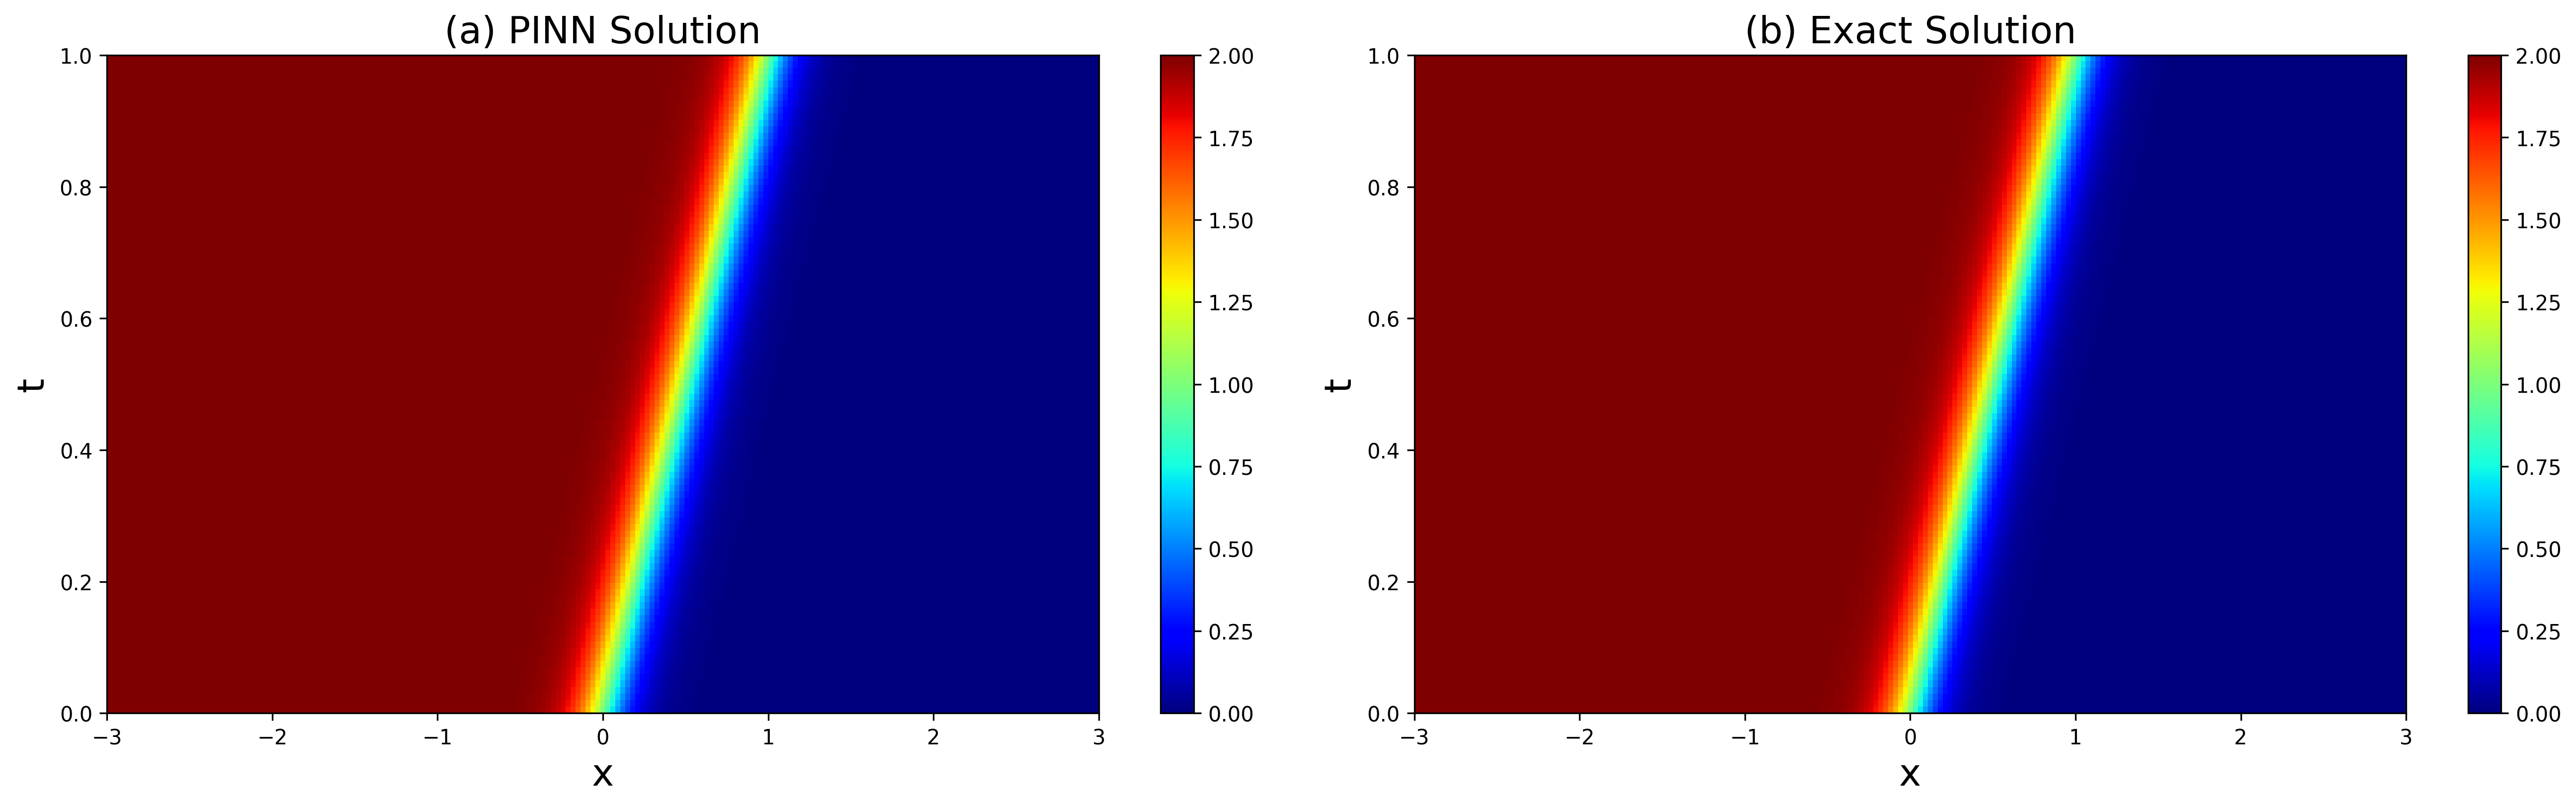

/tmp/ipython-input-2338595569.py:66: UserWarning: Adding colorbar to a different Figure <Figure size 2700x1800 with 2 Axes> than <Figure size 5400x1800 with 4 Axes> which fig.colorbar is called on.
  fig.colorbar(im3, ax=ax3)


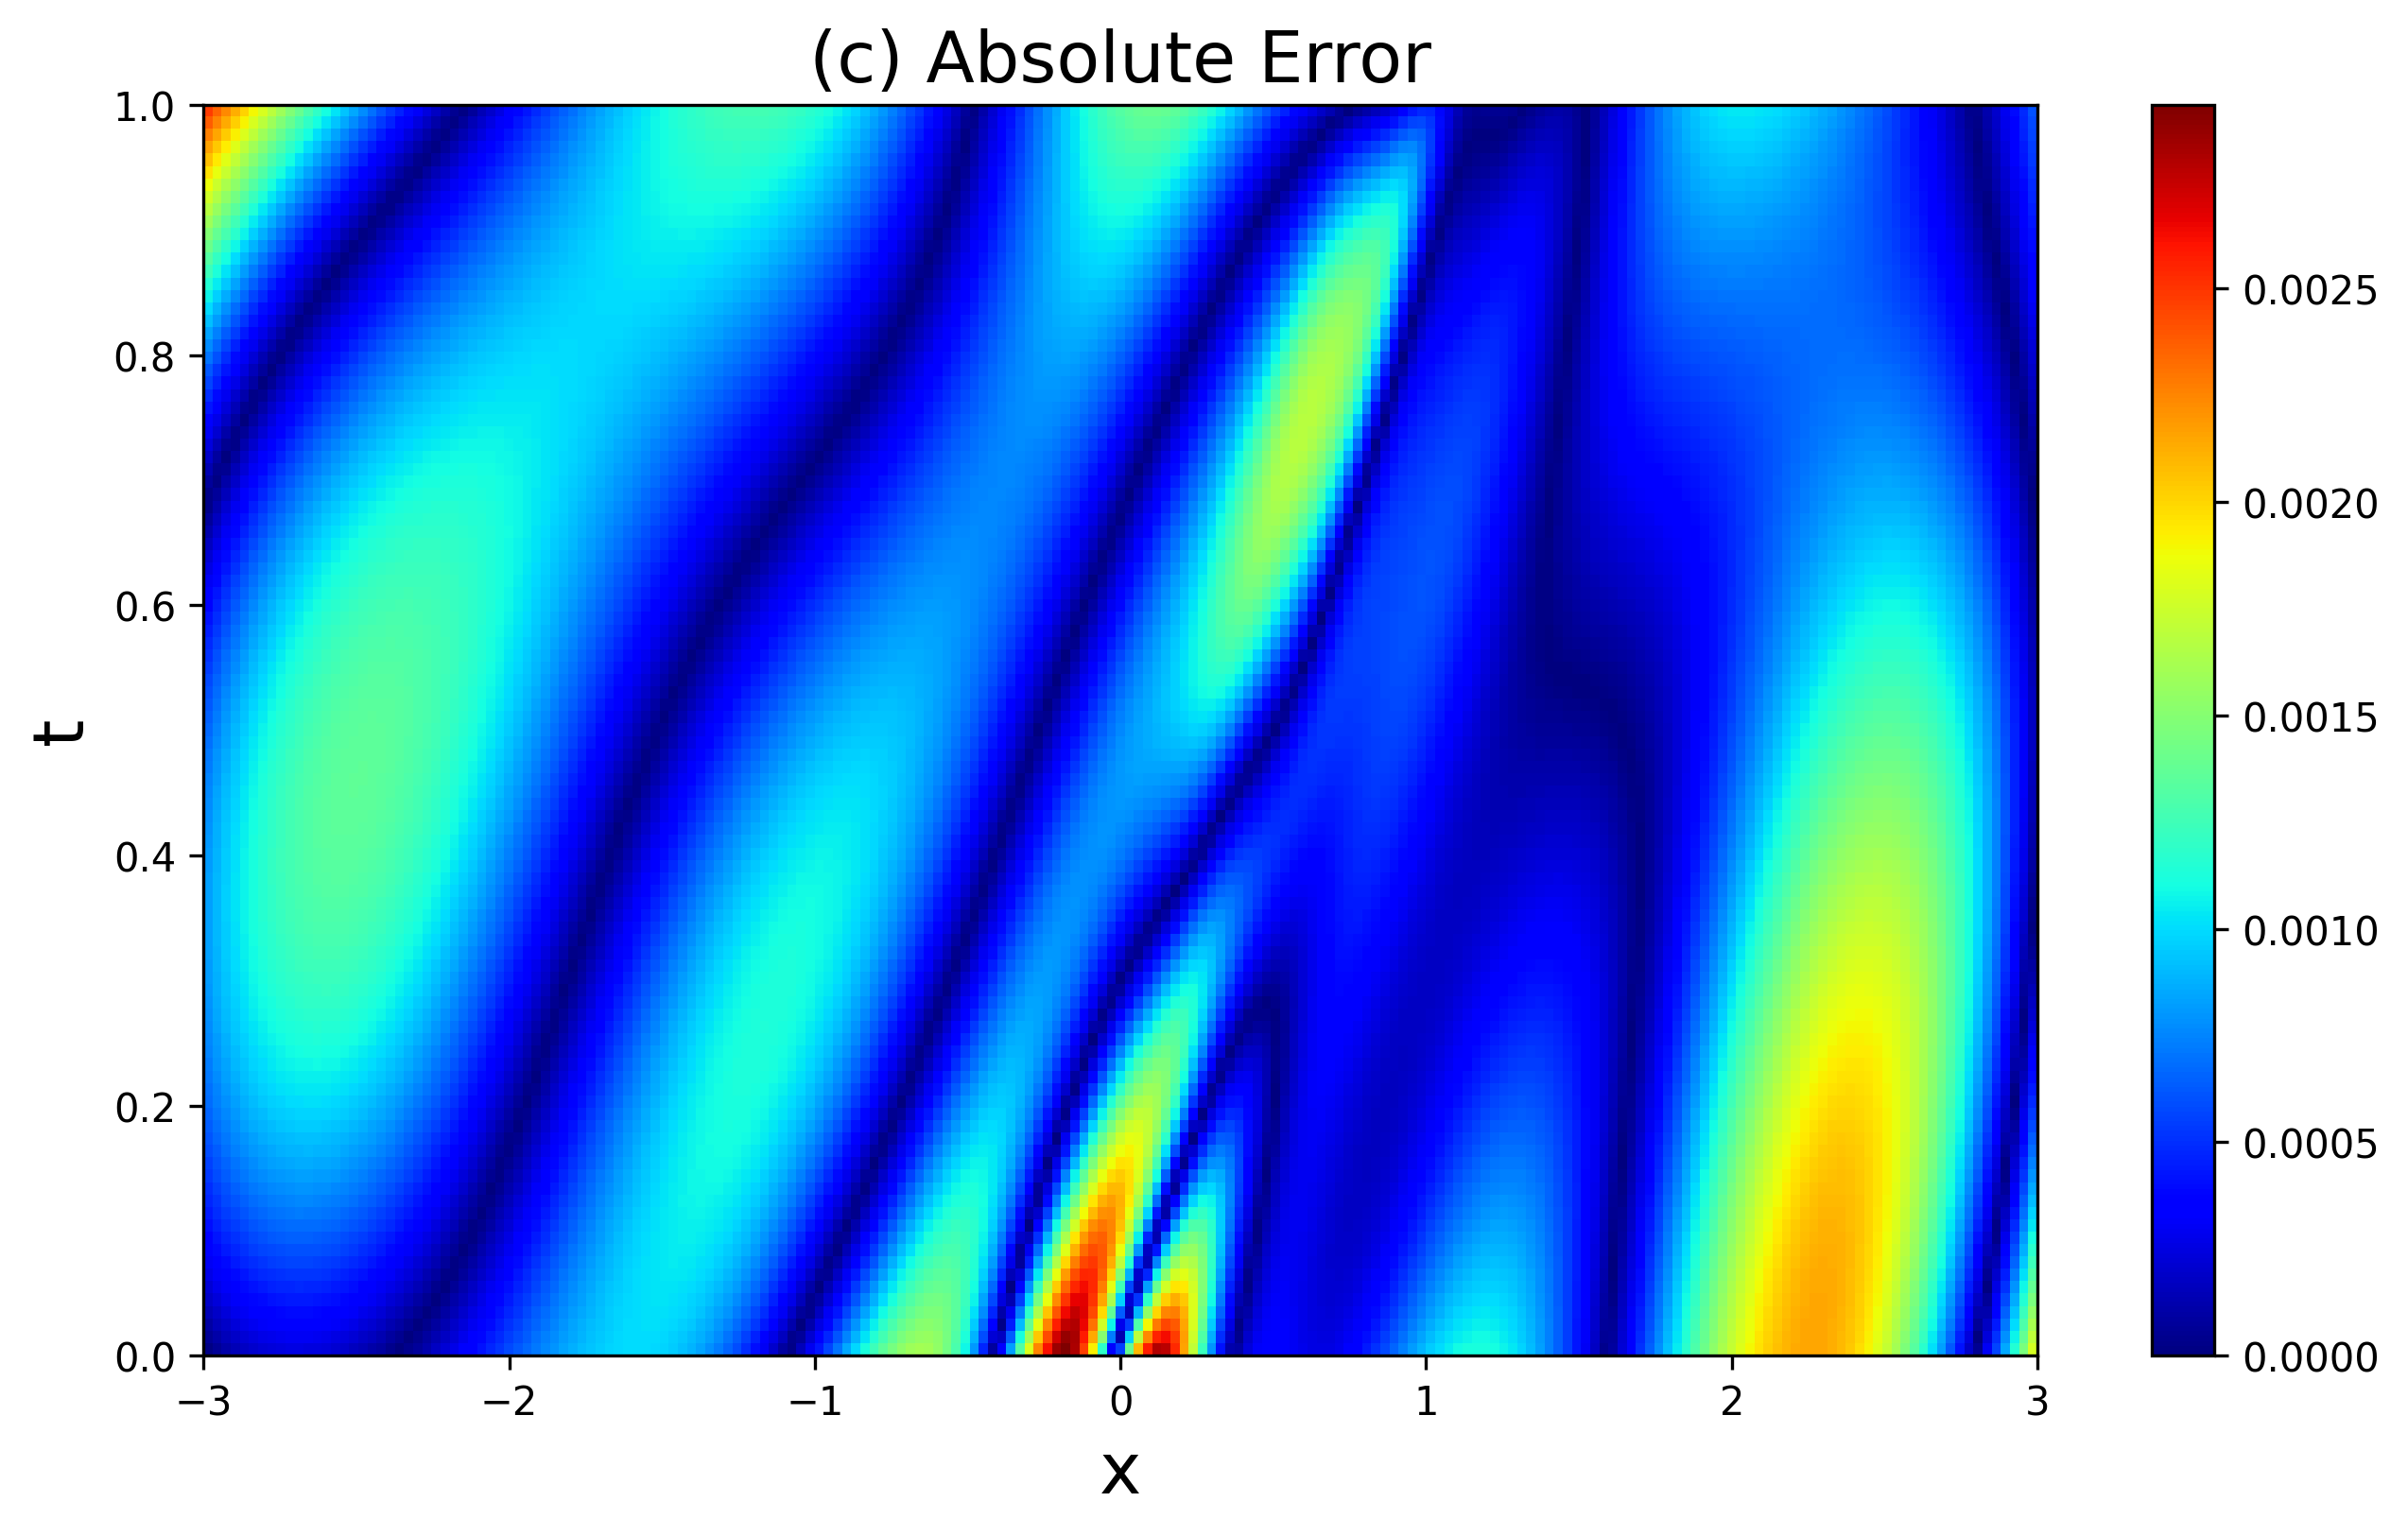

In [ ]:
# --------------------------------------------------
# 6. Evaluation and Visualization
# --------------------------------------------------
pinn_model.eval()

# Create a grid for plotting
x = torch.linspace(x_domain[0], x_domain[1], 201, device=device)
t = torch.linspace(t_domain[0], t_domain[1], 101, device=device)
X, T = torch.meshgrid(x, t, indexing='xy')
X_flat = X.flatten().view(-1, 1)
T_flat = T.flatten().view(-1, 1)

# Get PINN prediction and Exact solution on the grid
with torch.no_grad():
    u_pred = pinn_model(X_flat, T_flat)
    u_exact = exact_solution(X_flat, T_flat, nu)

U_pred = u_pred.reshape(X.shape).cpu().numpy()
U_exact = u_exact.reshape(X.shape).cpu().numpy()

# Calculate error
absolute_error = np.abs(U_pred - U_exact)
l2_relative_error = np.linalg.norm(U_pred - U_exact) / np.linalg.norm(U_exact)
print(f'\nL2 Relative Error: {l2_relative_error:.4e}')

# --- Plotting ---
fig = plt.figure(figsize=(18, 6),dpi =300) # Adjusted figure size for better layout
# Define a GridSpec with 2 rows and 2 columns
# The first row will have two plots (PINN and Exact Solution)
# The second row will have one plot (Absolute Error) spanning both columns
gs = GridSpec(1, 2, figure=fig)
#plt.suptitle("Burgers' Equation: PINN vs Exact Solution", fontsize=16)

# Plot PINN Solution in the first row, first column
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(U_pred, extent=[x_domain[0], x_domain[1], t_domain[0], t_domain[1]],
                 origin='lower', aspect='auto', cmap='jet', vmin=U_exact.min(), vmax=U_exact.max())
fig.colorbar(im1, ax=ax1)
ax1.set_xlabel('x', fontsize=18)
ax1.set_ylabel('t', fontsize=18)
ax1.set_title('(a) PINN Solution', fontsize=18)

# Plot Exact Solution in the first row, second column
ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(U_exact, extent=[x_domain[0], x_domain[1], t_domain[0], t_domain[1]],
                 origin='lower', aspect='auto', cmap='jet', vmin=U_exact.min(), vmax=U_exact.max())
fig.colorbar(im2, ax=ax2)
ax2.set_xlabel('x', fontsize=18)
ax2.set_ylabel('t', fontsize=18)
ax2.set_title('(b) Exact Solution', fontsize=18)

# Adjust layout to prevent overlap and ensure plots fit within the figure
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

fig2 = plt.figure(figsize=(9, 6), dpi =300) # Adjusted figure size for better layout
# Define a GridSpec with 2 rows and 2 columns
# The first row will have two plots (PINN and Exact Solution)
# The second row will have one plot (Absolute Error) spanning both columns
#plt.suptitle("Burgers' Equation: PINN vs Exact Solution", fontsize=16)
# Plot Absolute Error in the second row, spanning both columns
# This makes its horizontal size match the combined width of the two plots above
ax3 = fig2.add_subplot()
im3 = ax3.imshow(absolute_error, extent=[x_domain[0], x_domain[1], t_domain[0], t_domain[1]],
                 origin='lower', aspect='auto', cmap='jet')
fig.colorbar(im3, ax=ax3)
ax3.set_xlabel('x', fontsize=18)
ax3.set_ylabel('t', fontsize=18)
ax3.set_title('(c) Absolute Error', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
torch.random.manual_seed(42)
# Define the neural network
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )
        # Learnable parameter for diffusion coefficient (inverse problem)
        self.kappa = nn.Parameter(torch.tensor([0.1]))  # Initial guess

    def forward(self, x, t):
        xt = torch.cat((x, t), dim=1)
        return self.net(xt)

# PDE: du/dt = kappa * d²u/dx² (1D heat equation)
def pde_loss(model, x, t):
    x.requires_grad = True
    t.requires_grad = True
    u = model(x, t)

    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]

    f = u_t - model.kappa * u_xx
    return torch.mean(f**2)

# Boundary conditions: u(0,t) = u(1,t) = 0
def bc_loss(model, t):
    x_left = torch.zeros_like(t)
    x_right = torch.ones_like(t)
    u_left = model(x_left, t)
    u_right = model(x_right, t)
    return torch.mean(u_left**2) + torch.mean(u_right**2)

# Initial condition: u(x,0) = sin(pi x)
def ic_loss(model, x):
    t_zero = torch.zeros_like(x)
    u_ic = model(x, t_zero)
    target_ic = torch.sin(np.pi * x)
    return torch.mean((u_ic - target_ic)**2)

# Data loss for inverse problem (simulated measurements)
def data_loss(model, x_data, t_data, u_data):
    u_pred = model(x_data, t_data)
    return torch.mean((u_pred - u_data)**2)

kappa_values = []
epoch_values = []

# Training
def train(model, optimizer, epochs=10000):
    # Collocation points for PDE
    x_col = torch.rand(1000, 1) * 1.0  # Domain [0,1]
    t_col = torch.rand(1000, 1) * 1.0  # Time [0,1]

    # Points for BC
    t_bc = torch.rand(100, 1) * 1.0

    # Points for IC
    x_ic = torch.rand(100, 1) * 1.0

    # Simulated data points (assume true kappa=0.01, generate data)
    true_kappa = 0.01
    x_data = torch.rand(100, 1) * 1.0
    t_data = torch.rand(100, 1) * 1.0
    # Analytical solution for heat equation: u(x,t) = sin(pi x) * exp(-kappa pi^2 t)
    u_data = torch.sin(np.pi * x_data) * torch.exp(-true_kappa * (np.pi**2) * t_data)

    for epoch in range(epochs+1):
        optimizer.zero_grad()

        loss_pde = pde_loss(model, x_col, t_col)
        loss_bc = bc_loss(model, t_bc)
        loss_ic = ic_loss(model, x_ic)
        loss_data = data_loss(model, x_data, t_data, u_data)

        total_loss = loss_pde + loss_bc + loss_ic + loss_data
        total_loss.backward()
        optimizer.step()
        kappa_values.append(model.kappa.item())
        epoch_values.append(epoch)
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss.item():.6f}, Estimated kappa: {model.kappa.item():.6f}")

# Main
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train(model, optimizer)

# After training, the learned kappa should be close to 0.01
print(f"Learned diffusion coefficient: {model.kappa.item()}")

Epoch 0, Loss: 1.108532, Estimated kappa: 0.101000
Epoch 500, Loss: 0.000361, Estimated kappa: 0.010980
Epoch 1000, Loss: 0.000146, Estimated kappa: 0.009836
Epoch 1500, Loss: 0.000170, Estimated kappa: 0.009815
Epoch 2000, Loss: 0.000028, Estimated kappa: 0.009812
Epoch 2500, Loss: 0.000023, Estimated kappa: 0.009833
Epoch 3000, Loss: 0.000018, Estimated kappa: 0.009860
Epoch 3500, Loss: 0.000017, Estimated kappa: 0.009863
Epoch 4000, Loss: 0.000012, Estimated kappa: 0.009892
Epoch 4500, Loss: 0.000014, Estimated kappa: 0.009907
Epoch 5000, Loss: 0.000009, Estimated kappa: 0.009910
Epoch 5500, Loss: 0.000008, Estimated kappa: 0.009921
Epoch 6000, Loss: 0.000008, Estimated kappa: 0.009932
Epoch 6500, Loss: 0.000006, Estimated kappa: 0.009938
Epoch 7000, Loss: 0.000006, Estimated kappa: 0.009947
Epoch 7500, Loss: 0.000006, Estimated kappa: 0.009950
Epoch 8000, Loss: 0.000005, Estimated kappa: 0.009948
Epoch 8500, Loss: 0.000004, Estimated kappa: 0.009956
Epoch 9000, Loss: 0.000004, Esti

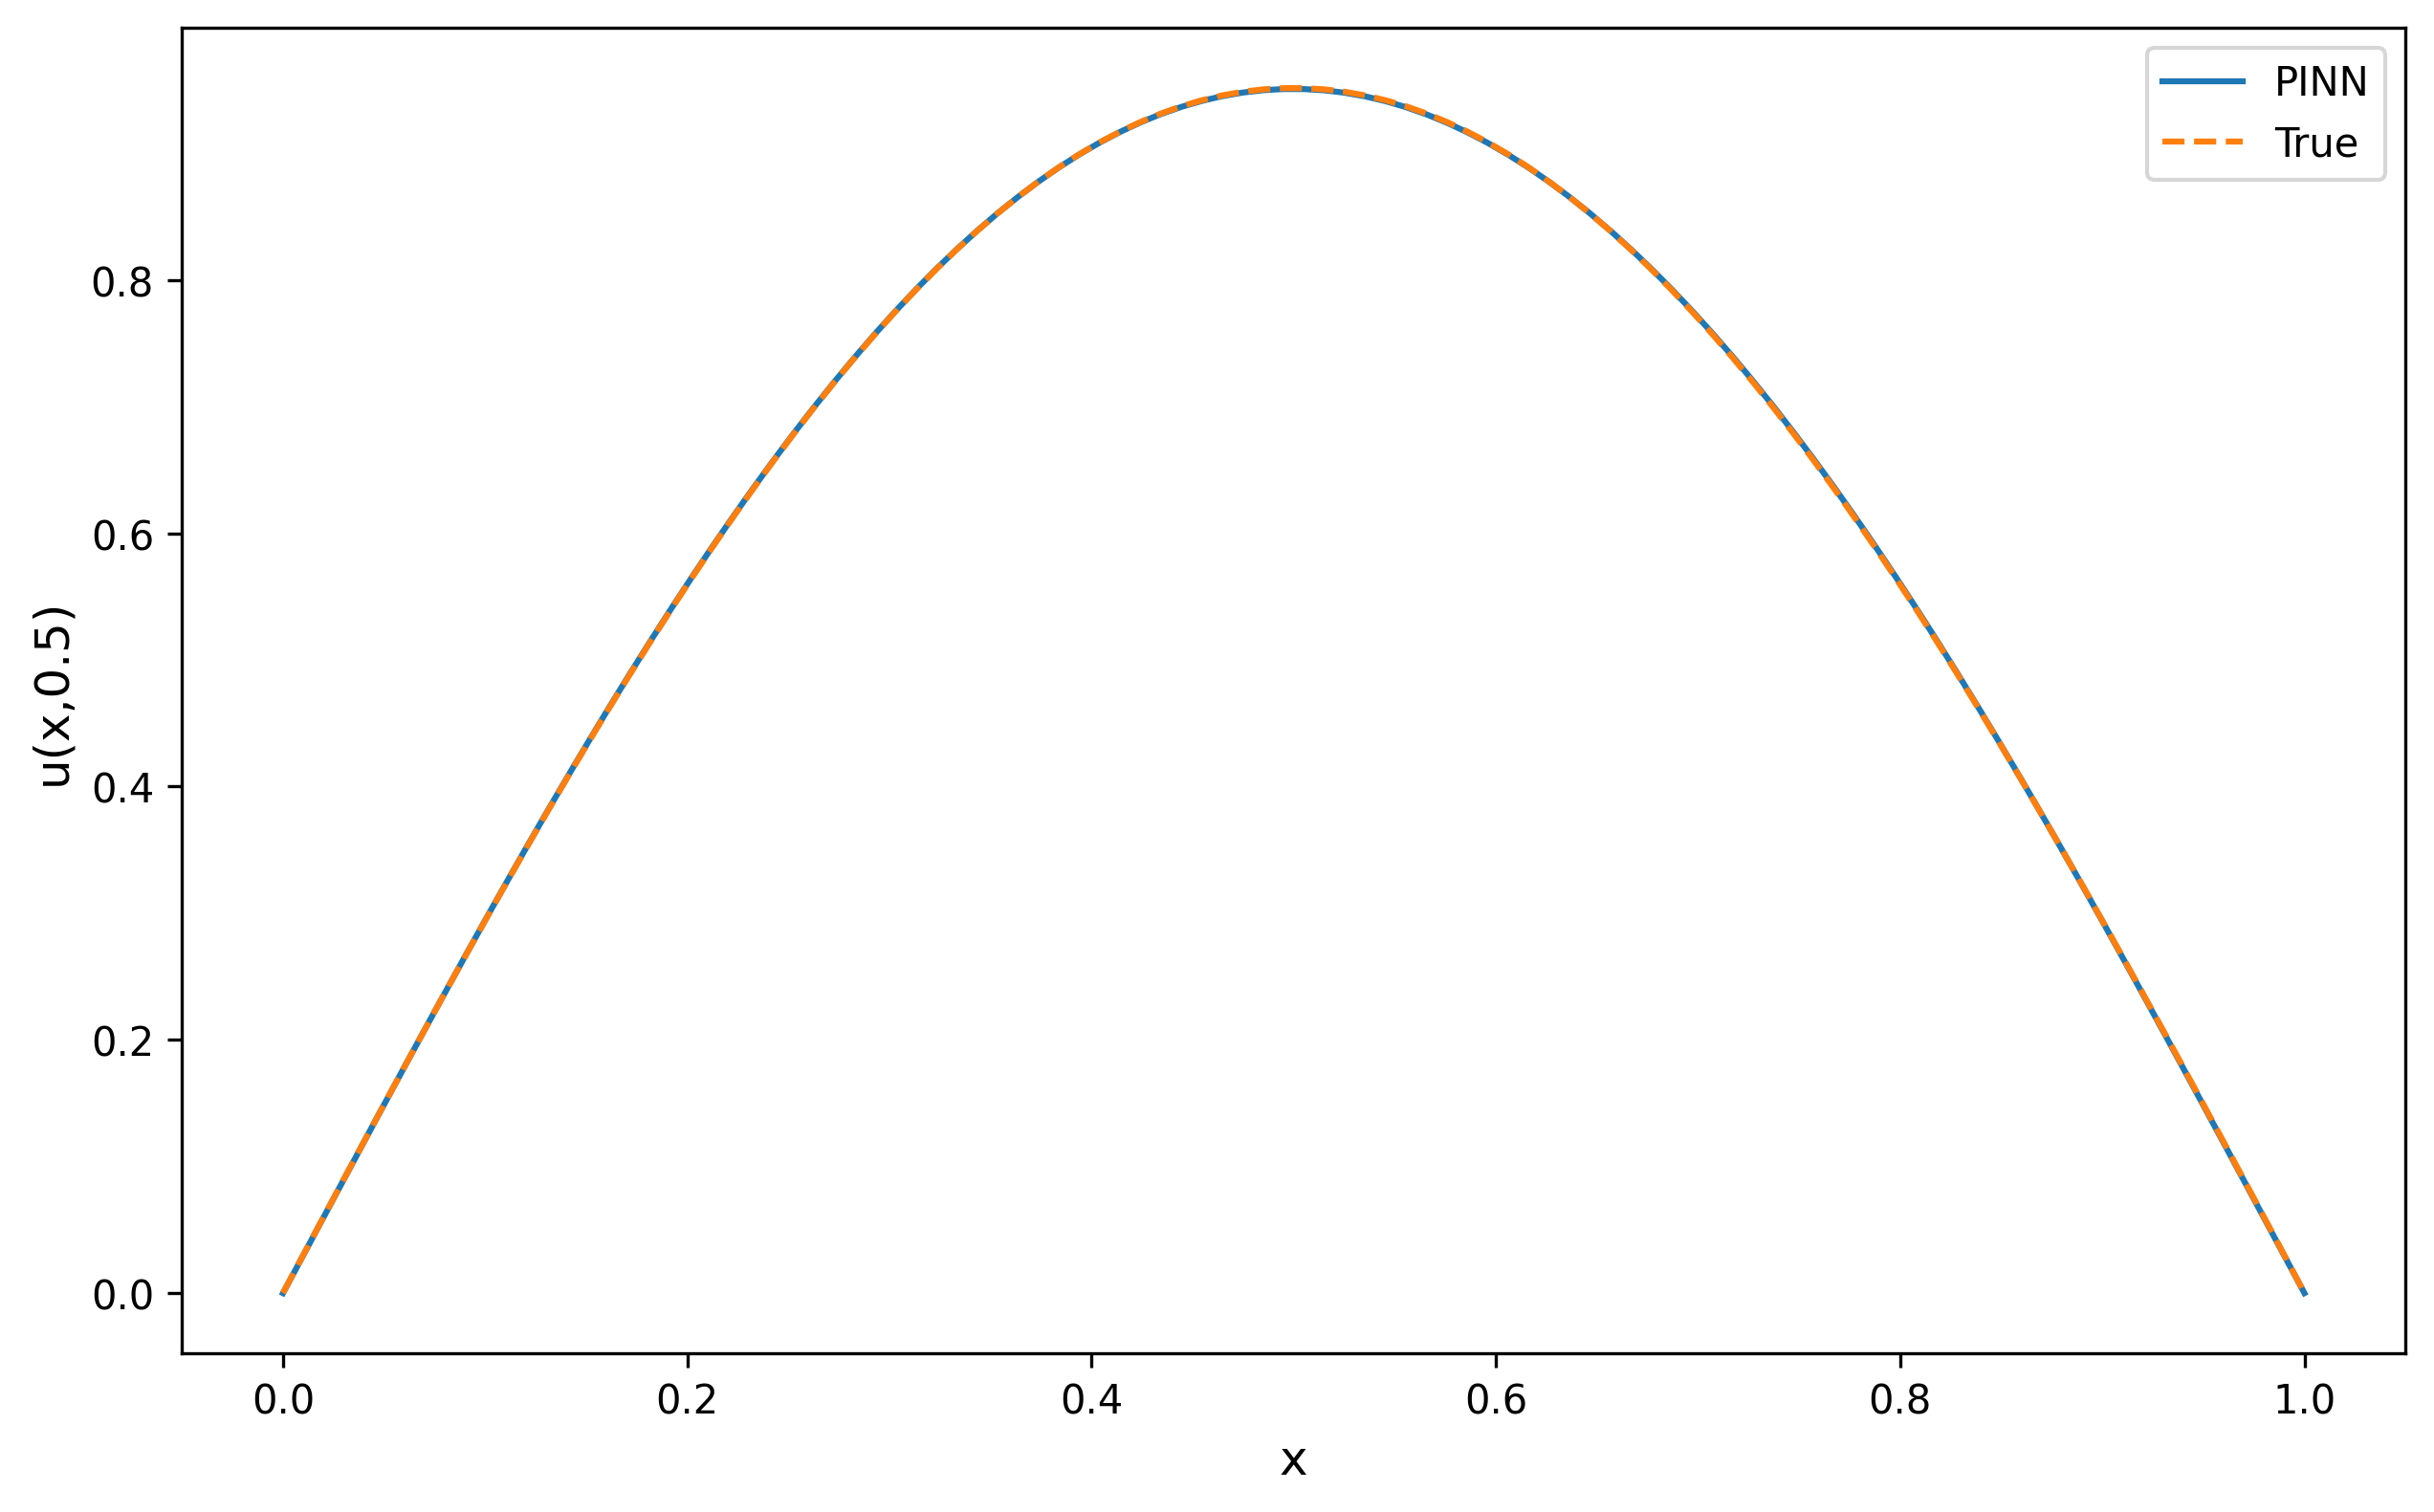

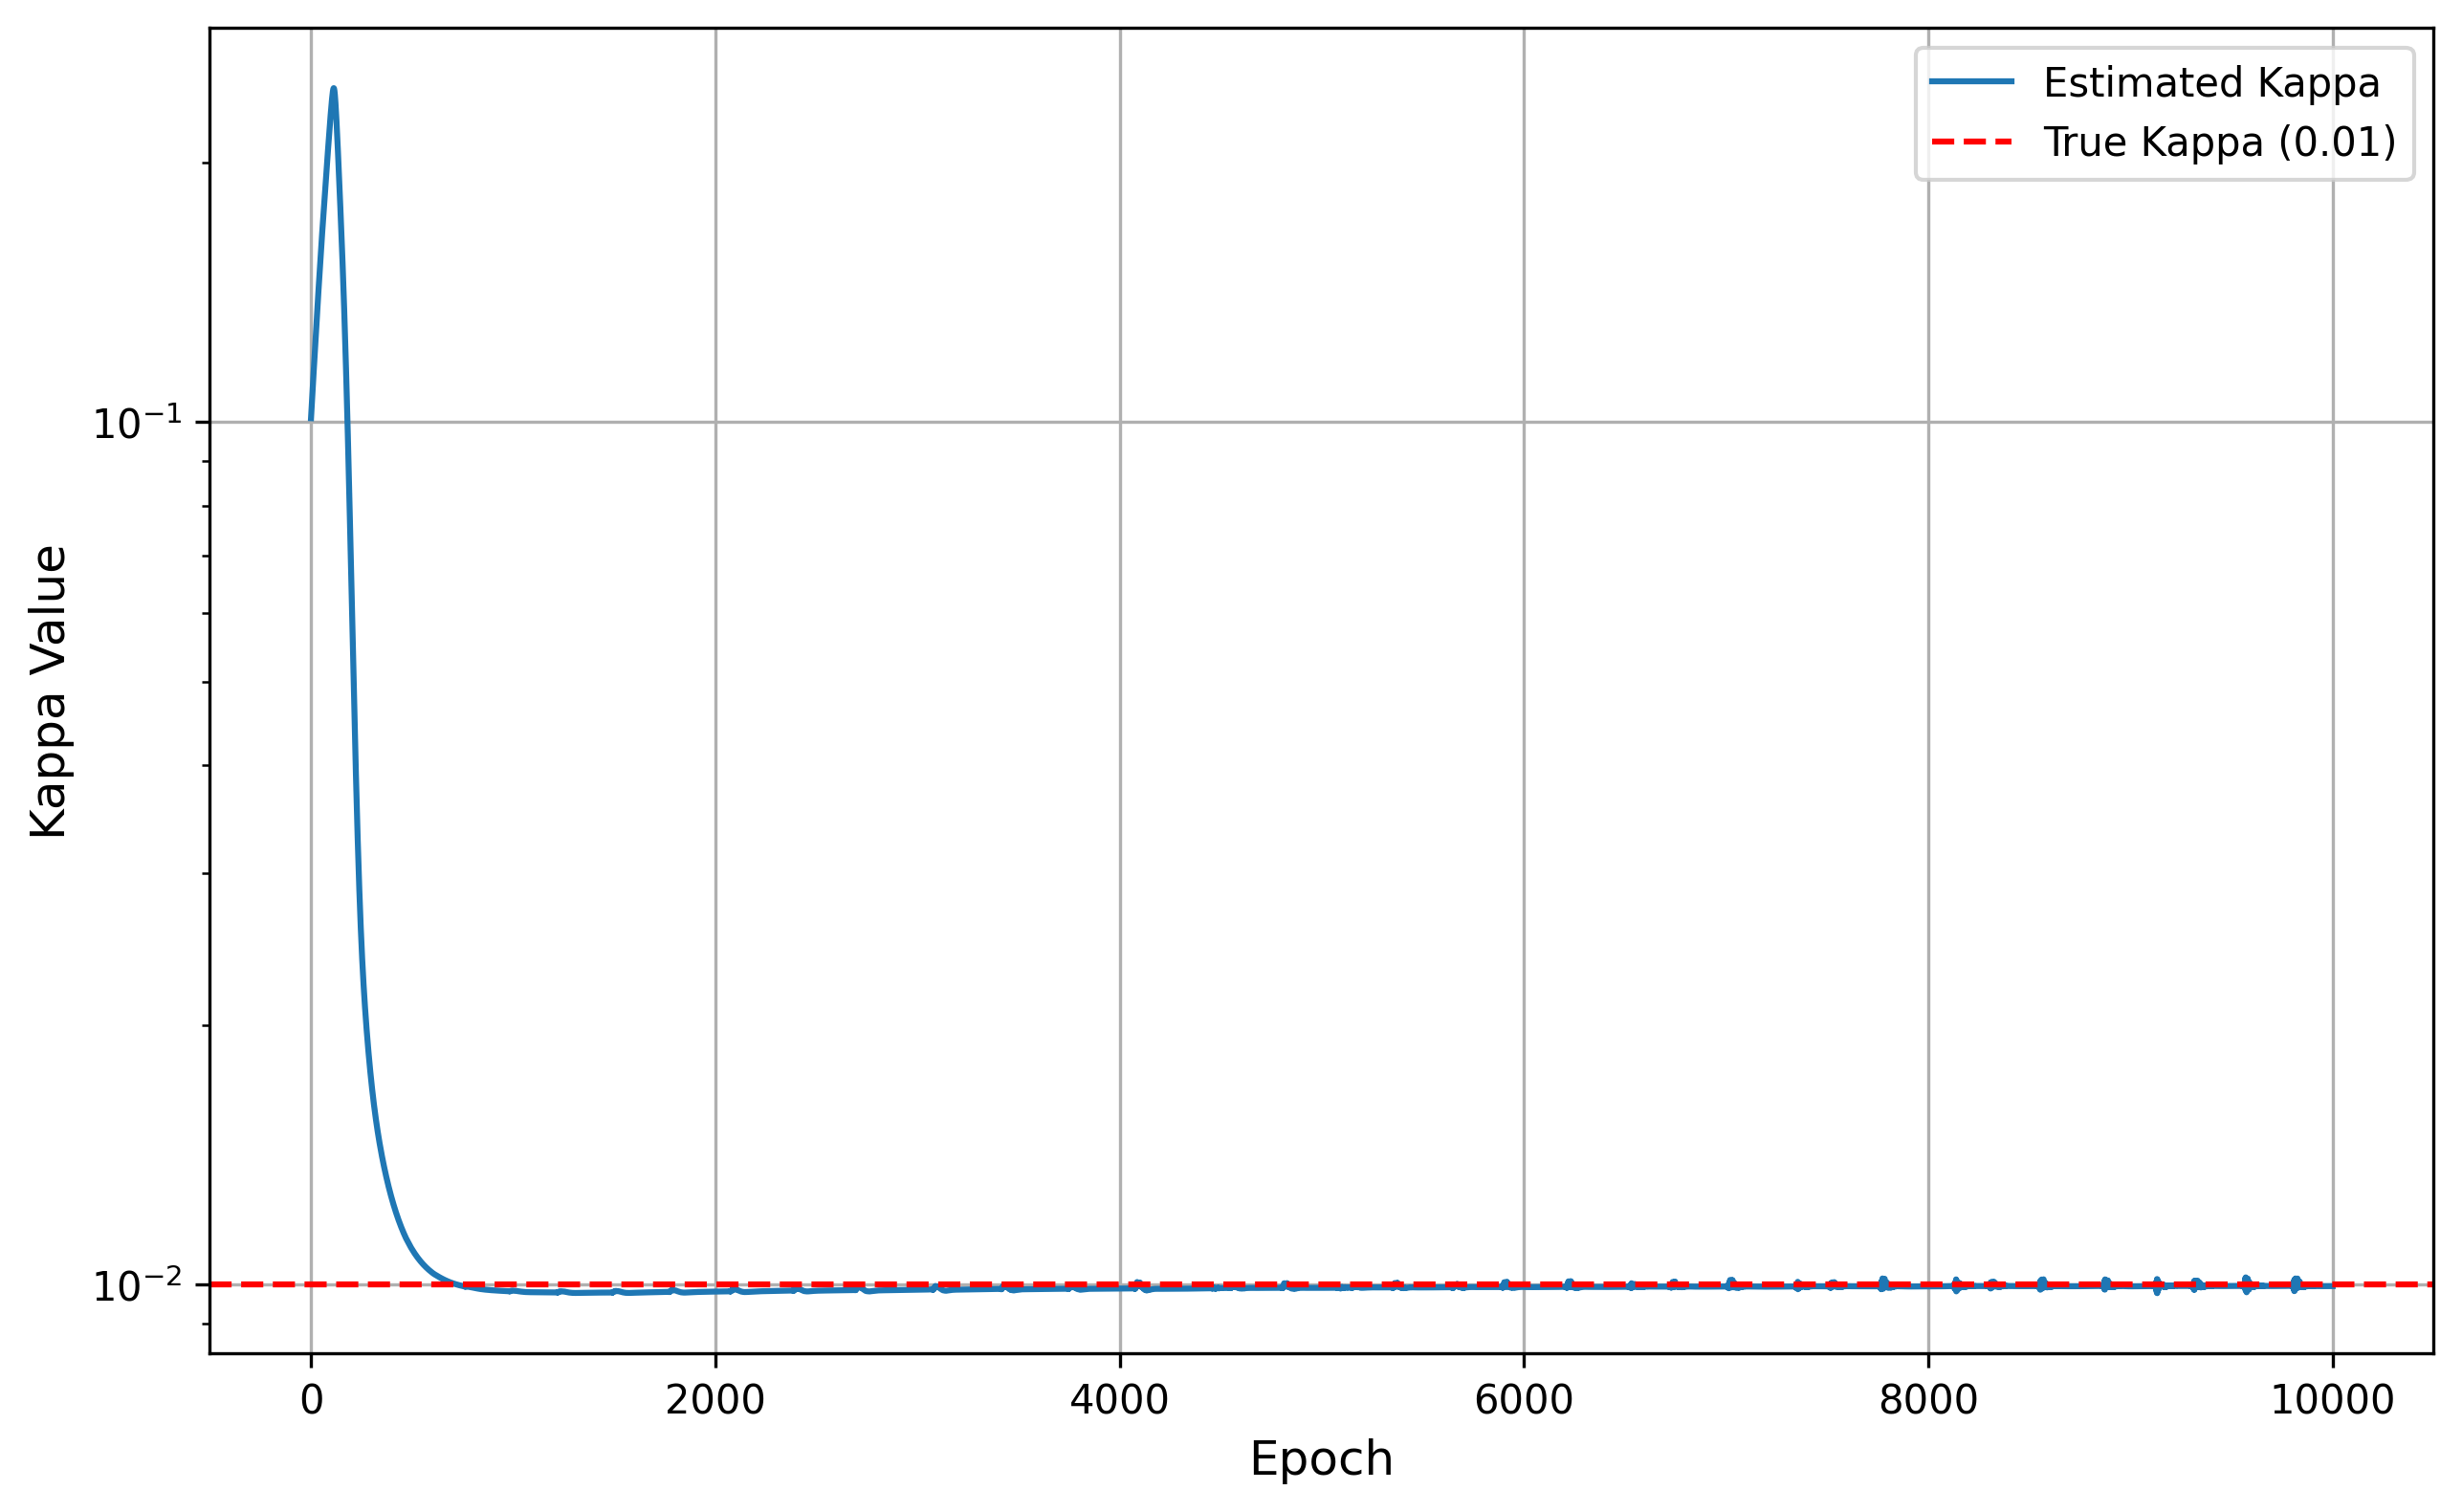

In [2]:
# Optional: Plot prediction vs analytical
plt.figure(figsize=(10, 6), dpi =300)
x_test = torch.linspace(0, 1, 100).unsqueeze(1)
t_test = torch.ones_like(x_test) * 0.5  # At t=0.5
u_pred = model(x_test, t_test).detach().numpy()
u_true = np.sin(np.pi * x_test.numpy()) * np.exp(-0.01 * (np.pi**2) * 0.5)
plt.plot(x_test.numpy(), u_pred, label='PINN')
plt.plot(x_test.numpy(), u_true, label='True', linestyle='--')
plt.xlabel('x', fontsize =12)
plt.ylabel('u(x,0.5)', fontsize =12)
#plt.title('PINN Prediction vs True Solution')
plt.legend()
plt.show()

# Plot kappa history
plt.figure(figsize=(10, 6), dpi =300)
plt.plot(epoch_values, kappa_values, label='Estimated Kappa')
plt.axhline(y=0.01, color='r', linestyle='--', label='True Kappa (0.01)')
plt.xlabel('Epoch', fontsize =12)
plt.ylabel('Kappa Value', fontsize =12)
plt.yscale('log') # Corrected from plt.logscale
#plt.title('Estimated Kappa Value During Training')
plt.legend()
plt.grid(True)
plt.show()